<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score
import spacy
from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

In [2]:
try:
    data = pd.read_csv('E:/BuduBogatym/toxic_comments.csv')
except:
    data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/toxic_comments.csv')

Загрузим необходимые файлы английской библиотеки

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Naix3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Naix3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Naix3\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Naix3\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


После предварительного просмотра сделан вывод о необходимости избавиться от регулярных выражений выражений с помощью `re`

Также необходимо очистить текст, создадим функцию clear_text

In [6]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text.lower())
    retext = text.split() 
    text = " ".join(retext)
    return text

In [7]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

Далее необходимо произвести токенизацию и лемматизацию:

In [8]:
def lemmetize(words):
    lemmatizer = WordNetLemmatizer() 
    text = [] # создаём список для заполнения
    tokens = word_tokenize(words) # токенизируем текст
    for token in tokens: # лемматизируем каждый токен
        lemmetized_word = lemmatizer.lemmatize(token,get_wordnet_pos(token)) 
        text.append(lemmetized_word)
    sentence = " ".join(text) # объединяем в текст обратно
    return sentence

Применим полученные функции к датасету

In [9]:
data['lemm_text'] = data['text'].apply(clear_text)
data['lemm_text'] = data['lemm_text'].apply(lemmetize)


In [10]:
data['lemm_text'].head(20)

0     explanation why the edits make under my userna...
1     d aww he match this background colour i m seem...
2     hey man i m really not try to edit war it s ju...
3     more i can t make any real suggestion on impro...
4     you sir be my hero any chance you remember wha...
5     congratulation from me a well use the tool wel...
6          cocksucker before you piss around on my work
7     your vandalism to the matt shirvington article...
8     sorry if the word nonsense be offensive to you...
9     alignment on this subject and which be contrar...
10    fair use rationale for image wonju jpg thanks ...
11    bbq be a man and let discus it maybe over the ...
12    hey what be it talk what be it an exclusive gr...
13    before you start throw accusation and warning ...
14    oh and the girl above start her argument with ...
15    juelz santanas age in juelz santana be year ol...
16    bye don t look come or think of comming back t...
17      redirect talk voydan pop georgiev cherno

Чтобы алгоритмы умели определять тематику и тональность текста, их нужно обучить на корпусе (англ. corpus). Это набор текстов, в котором эмоции и ключевые слова уже размечены.

Разделим датасет на тестовую и тренировочную выборку

In [11]:
train_features, test_features, train_target, test_target = train_test_split(
    data.drop('toxic', axis=1),
    data['toxic'],
    test_size=0.2,
    random_state=12345,
    stratify=data['toxic'] # стратифицируем текст, чтобы выборки были более сбалансированы
)

# вытаскиваем корпусы
corpus_train = train_features['lemm_text']
corpus_test = test_features['lemm_text']


In [12]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # подгружаем счетчик и задаём стоп-слова
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # обучаем и трансформируем
tf_idf_test = count_tf_idf.transform(corpus_test) # трансформируем тестовую без обучения

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)


Размер матрицы: (127433, 132707)
Размер матрицы: (31859, 132707)


Обработка данных завершена, TF-IDF посчитано

## Обучение

Создадим функцию для обучения моделей

In [13]:

# создаём таблицу для анализа
analisys = pd.DataFrame({'model':[], 'F1_model':[], 'F1_on_train':[],'time_to_predict':[], 'time_to_fit':[]})
all_models = []

# создаём функцию для подбора параметров
def train_model(model, parameters):
    
    model_random = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring='f1', 
        n_jobs=-1,
        cv=4, 
        verbose=2
    )
    
    # подсчитаем скорость вычисления
    start = time()
    model_random.fit(tf_idf_train, train_target) 
    print('GridSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    time_to_fit = model_random.cv_results_['mean_fit_time'][0]
    print('Время обучения модели %.2f секунд' %time_to_fit)
    
    time_to_predict = model_random.cv_results_['mean_score_time'][0]
    print('Модель предсказывает за %.2f секунд' %time_to_predict)
    
    # высчитаем метрики
    f1 = model_random.best_score_
    f1_on_train = f1_score(train_target, model_random.predict(tf_idf_train))
    
    print('Лучшие параметры:', model_random.best_params_)
    print('F1 обученной модели:', f1)
    print('F1 на тренировочной выборке:', f1_on_train)

    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, f1, f1_on_train, time_to_predict, time_to_fit])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

### Логистическая регрессия

In [14]:
ran_lr = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "class_weight": ['balanced', 'none'],
    'C': [5, 7, 9, 12, 14 ,15]
}

logr = LogisticRegression(max_iter=1000, random_state = 12345)

lr_random = train_model(logr, ran_lr)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
GridSearchCV подбирал параметры 615.39 секунд
Время обучения модели 0.08 секунд
Модель предсказывает за 0.00 секунд
Лучшие параметры: {'C': 14, 'class_weight': 'none', 'penalty': 'l2'}
F1 обученной модели: 0.7639010008484014
F1 на тренировочной выборке: 0.9214752643047373


### Дерево решений

In [15]:
ran_grid_tree = {
    "max_depth": list(range(45, 56))
}

dtr = DecisionTreeClassifier(random_state = 12345)

dtr_random = train_model(dtr, ran_grid_tree)

Fitting 4 folds for each of 11 candidates, totalling 44 fits
GridSearchCV подбирал параметры 315.92 секунд
Время обучения модели 71.42 секунд
Модель предсказывает за 0.06 секунд
Лучшие параметры: {'max_depth': 54}
F1 обученной модели: 0.7070030136979698
F1 на тренировочной выборке: 0.8293012569266116


### LightGBM

In [16]:
rand_lgbm_param = {
    'max_depth': [15, 25],
    'learning_rate': [0.1, 0.3]
}

gbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_jobs=-1
)

gbm_random= train_model(gbm, rand_lgbm_param)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
GridSearchCV подбирал параметры 124.12 секунд
Время обучения модели 73.62 секунд
Модель предсказывает за 0.96 секунд
Лучшие параметры: {'learning_rate': 0.3, 'max_depth': 25}
F1 обученной модели: 0.7627587040664444
F1 на тренировочной выборке: 0.8567658451453625


### XGBoost

In [17]:
rand_xgb_param = {
    'max_depth': [6, 7, 8, 9],
    'learning_rate': [0.5, 1.0]
}

xb = xgb.XGBClassifier(booster='gbtree', 
                      use_rmm=True,
                      n_jobs=-1)

xb_random = train_model(xb, rand_xgb_param)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
GridSearchCV подбирал параметры 492.40 секунд
Время обучения модели 131.40 секунд
Модель предсказывает за 0.16 секунд
Лучшие параметры: {'learning_rate': 0.5, 'max_depth': 9}
F1 обученной модели: 0.7526467243712532
F1 на тренировочной выборке: 0.8597312266540723


Выведем сводную таблицу по полученным данным

,model,F1_model,F1_on_train,time_to_predict,time_to_fit,names
0,"LogisticRegression(max_iter=1000, random_state...",0.763901,0.921475,0.000000,0.078545,LogisticRegression
1,DecisionTreeClassifier(random_state=12345),0.707003,0.829301,0.064313,71.417392,DecisionTree
2,LGBMClassifier(),0.762759,0.856766,0.955075,73.620402,LightGBM
3,"XGBClassifier(base_score=None, booster='gbtree...",0.752647,0.859731,0.156609,131.395701,XGBoost


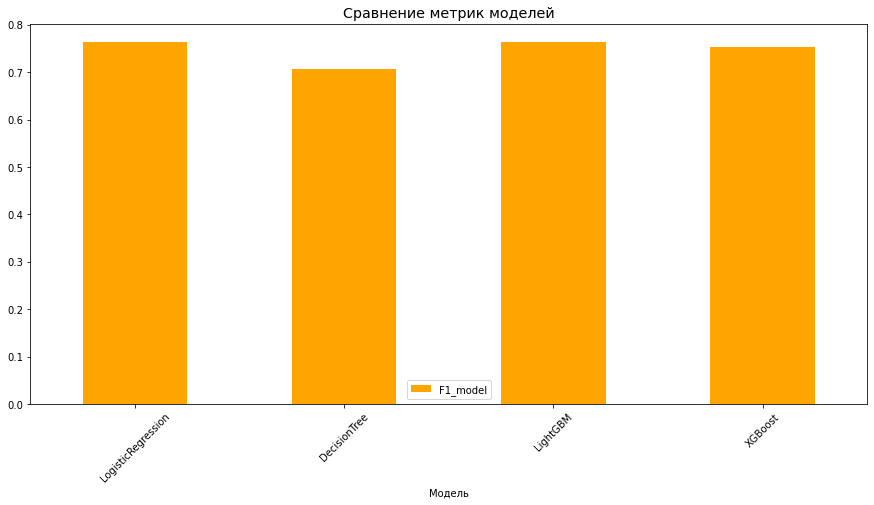

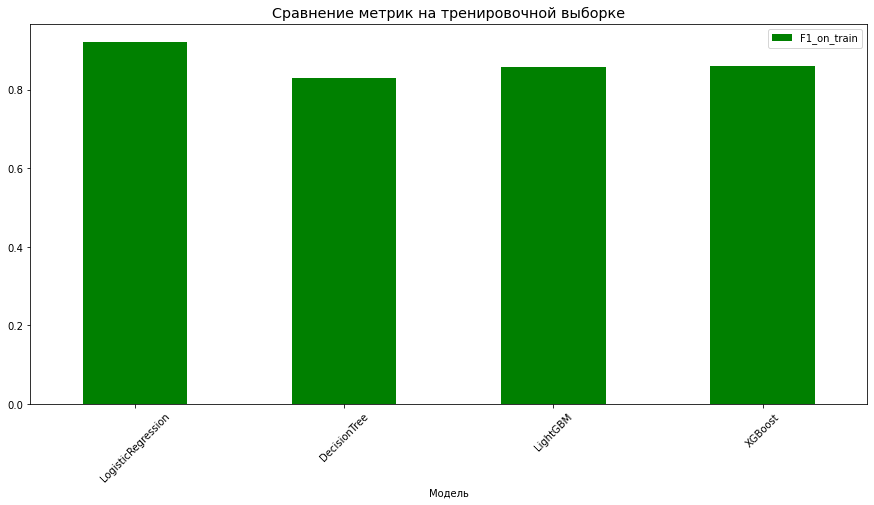

In [18]:
all_names = pd.DataFrame({'names':[ 'LogisticRegression', 'DecisionTree', 'LightGBM', 'XGBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='F1_model', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='F1_on_train', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение метрик на тренировочной выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

Исходя из полученных сводных таблиц выбор сделан в пользу LogisticRegression с параметрами C: 14, class_weight: none`, penalty: l2`, так как имеет лучшие метрики на обеих выборках.

## Выводы

Протестируем теперь полученную модель!

In [20]:
predicted = lr_random.predict(tf_idf_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(test_target, predicted))

F1 лучшей модели на тестовой выборке: 0.7784206943498979


Необходимые метрики достигнуты, модель LogisticRegression, обученная через GridSearchCV, предсказывает с необходимой метрикой: F1 > 0.75.